In [1]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import nd
from mxnet.gluon import nn
from mxnet import autograd

In [2]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape=y.shape)

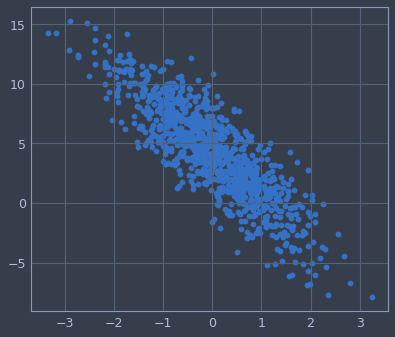

In [4]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

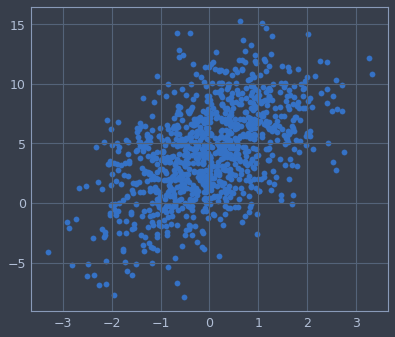

In [5]:
jtplot.style(theme='onedork')
plt.scatter(X[:, 0].asnumpy(), y.asnumpy())
plt.show()

In [11]:
import random
batch_size = 10
def data_iter():
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield nd.take(X, j), nd.take(y, j)

In [12]:
for data, label in data_iter():
    print(data, label)
    break


[[ 0.65387917 -0.94953394]
 [-0.18530272 -0.98280686]
 [-0.54901683 -0.58163607]
 [ 2.28999352 -0.12524648]
 [ 0.32756299  1.69395268]
 [-0.62045211 -2.91803932]
 [ 1.10606658  1.23735213]
 [-0.69712955  0.24541888]
 [ 0.8887381  -1.13854659]
 [-0.89255643  0.15500887]]
<NDArray 10x2 @cpu(0)> 
[  8.74401665   7.18655539   5.07518244   9.19657421  -0.89118439
  12.87809181   2.19637775   1.97265935   9.84523964   1.90580952]
<NDArray 10 @cpu(0)>


In [13]:
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1, ))
params = [w, b]

In [16]:
for param in params:
    param.attach_grad()

In [14]:
def net(X):
    return nd.dot(X, w) + b

In [15]:
def square_loss(yhat, y):
    return nd.power(yhat - y.reshape(yhat.shape), 2)

In [17]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [22]:
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '^b', label='Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 9.16533101689e-05. Average loss: 0.000091


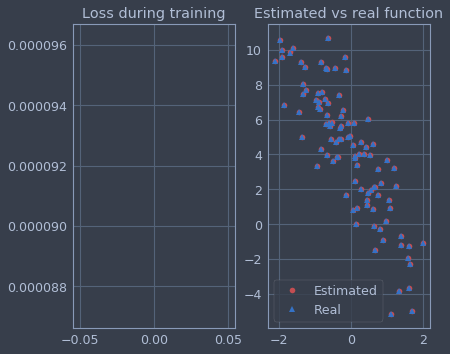

Epoch 1, batch 199. Moving avg of loss: 9.30408165919e-05. Average loss: 0.000091


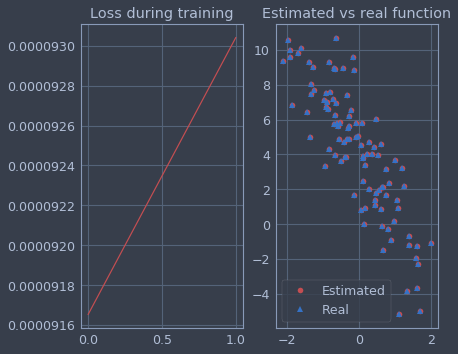

Epoch 2, batch 299. Moving avg of loss: 9.1955392953e-05. Average loss: 0.000090


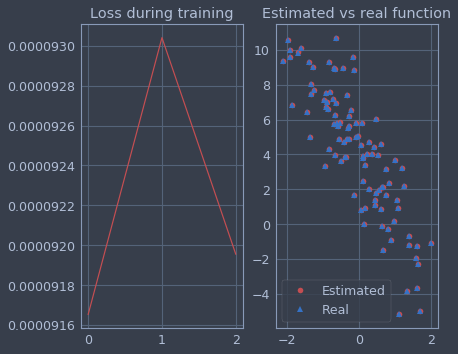

Epoch 3, batch 399. Moving avg of loss: 9.414642832e-05. Average loss: 0.000091


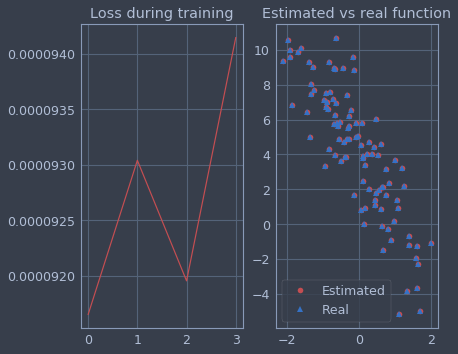

Epoch 4, batch 499. Moving avg of loss: 9.28697319054e-05. Average loss: 0.000091


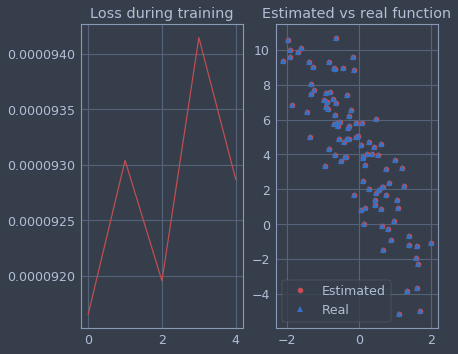

In [23]:
epochs = 5
learning_rate = .001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# 训练
for e in range(epochs):
    total_loss = 0

    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()

        # 记录每读取一个数据点后，损失的移动平均值的变化；
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)

        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
            plot(losses, X)